In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
RAW_TRAIN_PATH = '/mnt/c/Users/Hamlet/Documents/courses/fastai/data/1057_1913_bundle_archive/AirPassengers.csv'

In [4]:
%%time 
raw_df = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 6.12 ms, sys: 660 µs, total: 6.78 ms
Wall time: 14 ms


In [5]:
raw_df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
# make object dtype to datetime 
raw_df['Month'] = pd.to_datetime(raw_df['Month'])

In [7]:
TARGET = '#Passengers'

In [8]:
# lag the target by 6 month
raw_df['lag'] = raw_df[TARGET].shift(6)
raw_df.dropna(subset=['lag'], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

In [9]:
raw_df.head()

,Month,#Passengers,lag
0,1949-07-01,148,112.0
1,1949-08-01,148,118.0
2,1949-09-01,136,132.0
3,1949-10-01,119,129.0
4,1949-11-01,104,121.0


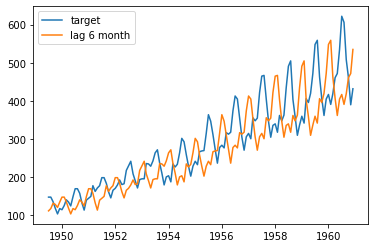

In [10]:
plt.plot(raw_df['Month'], raw_df[TARGET], label='target')
plt.plot(raw_df['Month'], raw_df['lag'], label='lag 6 month')
plt.legend()

In [11]:
raw_df.tail(10)

,Month,#Passengers,lag
128,1960-03-01,419,463.0
129,1960-04-01,461,407.0
130,1960-05-01,472,362.0
131,1960-06-01,535,405.0
132,1960-07-01,622,417.0
133,1960-08-01,606,391.0
134,1960-09-01,508,419.0
135,1960-10-01,461,461.0
136,1960-11-01,390,472.0
137,1960-12-01,432,535.0


In [12]:
EVAL_PERIOD = ['1955-12-01', '1960-12-01']

In [13]:
EVAL_PERIOD

['1955-12-01', '1960-12-01']

In [14]:
valid_idx = raw_df['Month'].between(*EVAL_PERIOD)
train_idx = raw_df['Month'] < EVAL_PERIOD[0]

In [15]:
train_data = raw_df.loc[train_idx, :].reset_index(drop=True)
valid_data = raw_df.loc[valid_idx, :].reset_index(drop=True)

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
RAW_FEATURES = ['lag']

In [18]:
# normalize feature from 0 to 1.
scaler = MinMaxScaler()
train_data[RAW_FEATURES] = scaler.fit_transform(train_data[RAW_FEATURES])
valid_data[RAW_FEATURES] = scaler.transform(valid_data[RAW_FEATURES])

In [19]:
from typing import Tuple, List

class TimeSeriesDataset:
    def __init__(self, features: np.ndarray,
                 target: np.ndarray,
                 lags: int = 0):
        self.features = features
        self.target = target
        self.lags = lags

    def __len__(self) -> int:
        return len(self.target)
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        assert index >= 0 and index < len(self.target), \
               f'index={index} out of range, {0}>={index}<{len(self.target)}'
        train_indices = np.arange(index - self.lags, index) + 1
        train_indices[train_indices < 0] = 0
        
        return self.features[train_indices], self.target[index]

    @classmethod
    def from_dataframe(cls, data: pd.DataFrame,
                       features: List[str],
                       target: List[str],
                       lags: int = 0):
        features_values = data.loc[:, features].to_numpy().astype(np.float32)
        target_values = data.loc[:, target].to_numpy().astype(np.float32)
        
        return cls(features_values, target_values, lags=lags)

In [20]:
def test_time_series_ds(verbose=False):
    size = 100
    lag = 5
    x = np.random.randn(size)
    y = np.random.randn(size)
    
    ds = TimeSeriesDataset(x, y, lags=lag)
    
    for i in range(len(ds)):
        expected_x = list(x[max(0, i-lag+1):i+1]) # include the input
        actual_x, _ = ds[i]
        assert len(actual_x) == lag
        # remove padding
        actual_x = actual_x[-min(0, i-lag+1):]
        
        error_msg =  f'{expected_x}-{actual_x}'
        if verbose:
            print(error_msg)
        assert list(expected_x) == list(actual_x), error_msg

test_time_series_ds()

In [21]:
import torch
from torch import nn, optim
# IGNORE

def compute_cnn_output_dim(Lin: int, C: nn.Conv1d) -> int:    
    padding = 2 * C.padding[0]
    kernel = C.dilation[0] * (C.kernel_size[0] - 1)
    Lout = (Lin + padding - kernel - 1) / C.stride[0]
    assert Lout % 1 == 0
    return int(Lout) + 1

def test_compute_cnn_output_dim():
    kernel_size = np.random.randint(10, 30)
    conv = nn.Conv1d(5, 100, kernel_size=kernel_size)
    
    for _ in range(100):
        Lin = np.random.randint(kernel_size, 100)
        x = torch.randn(64, 5, Lin)
        e = conv(x).shape[-1]
        assert e == compute_cnn_output_dim(Lin, conv)
test_compute_cnn_output_dim()

In [22]:
import torch
from torch import nn, optim
from functools import reduce
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm.auto import tqdm


def build_cnn_layer(input_dim: int, output_dim: int,
                    kernel_size: int = 3,
                    batch_bn: bool = False,
                    dropout: float = 0.,
                    relu: bool = False) -> nn.Sequential:
    output_layer = []
    # conv layer
    layer = nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size)
    output_layer.append(layer)
    if relu:
        output_layer.append(nn.ReLU())
    if batch_bn:
        output_layer.append(nn.BatchNorm1d(output_dim))
    if dropout > 0.:
        output_layer.append(nn.Dropout(dropout))
    return nn.Sequential(*output_layer)


class CnnModel(nn.Module):
    def __init__(self, input_dim: int,
                 lags: int,
                 output_dim: int):
        super().__init__()
        filters = [input_dim, 8, 16]
        
        self.cnns = nn.Sequential(*[build_cnn_layer(input_dim, output_dim, batch_bn=False,
                                                    relu=True)
                                    for input_dim, output_dim in zip(filters[:-1], filters[1:])])
        
        
        output_cnn = 3
        
        out_cnn_feat = filters[-1] * output_cnn
        
        self.decoder = nn.Linear(out_cnn_feat, output_dim)
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        # input x shape: bs, sq, ft
        # expected bs, ft, sq
        x = x.transpose(2, 1)
        x = self.cnns(x).flatten(1)
        return self.decoder(x)

    
def train(model: nn.Module, optimizer: optim.Optimizer, train_dl: DataLoader):
    model.train()
    for i, (x, y) in enumerate(train_dl):
        # zero all gradients
        optimizer.zero_grad()
        # forward pass
        yhat = model(x)
        # loss
        loss = F.mse_loss(yhat, y)
        # backward pass
        loss.backward()
        # update params
        optimizer.step()
        if i % 100 == 0:
            print(f'iter {i}, loss={loss.item()}')

In [23]:
LAGS = 7
BATCH_SIZE=64

In [24]:
train_ds = TimeSeriesDataset.from_dataframe(train_data, features=RAW_FEATURES,
                                            target=[TARGET], lags=LAGS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
valid_ds = TimeSeriesDataset.from_dataframe(valid_data, features=RAW_FEATURES,
                                            target=[TARGET], lags=LAGS)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [26]:
model = CnnModel(len(RAW_FEATURES), LAGS, 1)
opt = optim.Adam(model.parameters(), lr=0.1)

In [27]:
model

CnnModel(
  (cnns): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (decoder): Linear(in_features=48, out_features=1, bias=True)
)

In [28]:
for e in range(1500):
    train(model, opt, train_dl)

iter 0, loss=42927.8046875
iter 0, loss=44458.578125
iter 0, loss=35769.6328125
iter 0, loss=25436.771484375
iter 0, loss=9739.287109375
iter 0, loss=1625.0511474609375
iter 0, loss=11939.072265625
iter 0, loss=5780.74609375
iter 0, loss=1258.9814453125
iter 0, loss=3561.23388671875
iter 0, loss=6353.44189453125
iter 0, loss=6426.16357421875
iter 0, loss=4134.6005859375
iter 0, loss=1907.9703369140625
iter 0, loss=1489.95361328125
iter 0, loss=2954.6640625
iter 0, loss=2586.53662109375
iter 0, loss=1554.2769775390625
iter 0, loss=1389.9595947265625
iter 0, loss=1636.9046630859375
iter 0, loss=2336.67138671875
iter 0, loss=1775.3189697265625
iter 0, loss=1278.94482421875
iter 0, loss=1168.7049560546875
iter 0, loss=1397.853271484375
iter 0, loss=1338.1439208984375
iter 0, loss=1185.355712890625
iter 0, loss=1235.7421875
iter 0, loss=1013.4638671875
iter 0, loss=1279.6927490234375
iter 0, loss=1213.6746826171875
iter 0, loss=1274.20166015625
iter 0, loss=1098.377685546875
iter 0, loss=11

iter 0, loss=200.32937622070312
iter 0, loss=222.52635192871094
iter 0, loss=289.50341796875
iter 0, loss=248.66635131835938
iter 0, loss=181.86465454101562
iter 0, loss=193.31069946289062
iter 0, loss=223.31858825683594
iter 0, loss=201.2660369873047
iter 0, loss=246.11441040039062
iter 0, loss=219.64492797851562
iter 0, loss=187.26344299316406
iter 0, loss=237.25144958496094
iter 0, loss=198.29135131835938
iter 0, loss=224.32308959960938
iter 0, loss=203.41641235351562
iter 0, loss=283.9325866699219
iter 0, loss=226.28469848632812
iter 0, loss=264.17352294921875
iter 0, loss=205.38328552246094
iter 0, loss=222.09042358398438
iter 0, loss=239.13088989257812
iter 0, loss=230.80662536621094
iter 0, loss=219.6663055419922
iter 0, loss=196.1373291015625
iter 0, loss=223.5323944091797
iter 0, loss=206.02294921875
iter 0, loss=204.05767822265625
iter 0, loss=222.23208618164062
iter 0, loss=229.00576782226562
iter 0, loss=182.7008819580078
iter 0, loss=232.1243896484375
iter 0, loss=241.6668

iter 0, loss=213.956298828125
iter 0, loss=219.63388061523438
iter 0, loss=206.21815490722656
iter 0, loss=216.06881713867188
iter 0, loss=205.11648559570312
iter 0, loss=217.1295623779297
iter 0, loss=206.9946746826172
iter 0, loss=209.3578643798828
iter 0, loss=201.0124969482422
iter 0, loss=182.37493896484375
iter 0, loss=219.2488555908203
iter 0, loss=198.59239196777344
iter 0, loss=189.12930297851562
iter 0, loss=193.00372314453125
iter 0, loss=175.2620849609375
iter 0, loss=265.3933410644531
iter 0, loss=221.15292358398438
iter 0, loss=191.66619873046875
iter 0, loss=212.48794555664062
iter 0, loss=288.5978088378906
iter 0, loss=262.72442626953125
iter 0, loss=211.16915893554688
iter 0, loss=241.96737670898438
iter 0, loss=192.34292602539062
iter 0, loss=225.8554229736328
iter 0, loss=198.87782287597656
iter 0, loss=257.3419494628906
iter 0, loss=221.92681884765625
iter 0, loss=235.7532196044922
iter 0, loss=265.2052001953125
iter 0, loss=219.0917205810547
iter 0, loss=325.775299

iter 0, loss=254.28189086914062
iter 0, loss=225.21328735351562
iter 0, loss=215.09332275390625
iter 0, loss=230.939697265625
iter 0, loss=219.12339782714844
iter 0, loss=178.2351837158203
iter 0, loss=240.142333984375
iter 0, loss=207.14414978027344
iter 0, loss=214.299560546875
iter 0, loss=198.65185546875
iter 0, loss=209.03201293945312
iter 0, loss=228.00091552734375
iter 0, loss=220.7215576171875
iter 0, loss=203.1961669921875
iter 0, loss=206.96946716308594
iter 0, loss=237.03018188476562
iter 0, loss=213.46658325195312
iter 0, loss=202.6456298828125
iter 0, loss=222.78765869140625
iter 0, loss=212.5471649169922
iter 0, loss=201.54302978515625
iter 0, loss=167.98960876464844
iter 0, loss=186.08865356445312
iter 0, loss=218.49008178710938
iter 0, loss=201.00311279296875
iter 0, loss=206.56631469726562
iter 0, loss=214.8781280517578
iter 0, loss=194.818115234375
iter 0, loss=222.46429443359375
iter 0, loss=172.4547576904297
iter 0, loss=226.30238342285156
iter 0, loss=166.909255981

iter 0, loss=241.0846710205078
iter 0, loss=327.9449157714844
iter 0, loss=284.79937744140625
iter 0, loss=203.5970916748047
iter 0, loss=212.99310302734375
iter 0, loss=206.22425842285156
iter 0, loss=218.7836456298828
iter 0, loss=218.78123474121094
iter 0, loss=334.47845458984375
iter 0, loss=213.1441192626953
iter 0, loss=219.0668182373047
iter 0, loss=380.8548278808594
iter 0, loss=215.2618865966797
iter 0, loss=243.61155700683594
iter 0, loss=290.30645751953125
iter 0, loss=219.7461700439453
iter 0, loss=275.1068115234375
iter 0, loss=210.08164978027344
iter 0, loss=284.47418212890625
iter 0, loss=198.88014221191406
iter 0, loss=233.40579223632812
iter 0, loss=187.43896484375
iter 0, loss=203.28860473632812
iter 0, loss=247.0006103515625
iter 0, loss=202.66062927246094
iter 0, loss=181.60398864746094
iter 0, loss=295.8659362792969
iter 0, loss=195.66558837890625
iter 0, loss=241.99844360351562
iter 0, loss=202.778564453125
iter 0, loss=185.47784423828125
iter 0, loss=209.45439147

iter 0, loss=200.99005126953125
iter 0, loss=262.38916015625
iter 0, loss=208.31674194335938
iter 0, loss=208.65985107421875
iter 0, loss=224.51943969726562
iter 0, loss=203.90965270996094
iter 0, loss=215.34344482421875
iter 0, loss=218.8237762451172
iter 0, loss=214.18112182617188
iter 0, loss=250.88583374023438
iter 0, loss=209.85256958007812
iter 0, loss=184.8518524169922
iter 0, loss=187.13046264648438
iter 0, loss=209.2374267578125
iter 0, loss=195.75018310546875
iter 0, loss=190.83058166503906
iter 0, loss=208.5149688720703
iter 0, loss=273.8262023925781
iter 0, loss=214.214599609375
iter 0, loss=262.1715087890625
iter 0, loss=213.0880584716797
iter 0, loss=315.11700439453125
iter 0, loss=229.49696350097656
iter 0, loss=192.52822875976562
iter 0, loss=224.5723876953125
iter 0, loss=186.45542907714844
iter 0, loss=183.41346740722656
iter 0, loss=213.59378051757812
iter 0, loss=239.7317352294922
iter 0, loss=247.85897827148438
iter 0, loss=174.9686737060547
iter 0, loss=234.378967

In [29]:
def predict_dl(model: nn.Module, dl: DataLoader):
    model.eval()
    with torch.no_grad():
        yhat = torch.cat([model(x) for x, _ in dl])
    return yhat.numpy()

In [30]:
valid_yhat = predict_dl(model, valid_dl).ravel()

In [31]:
valid_data['yhat'] = valid_yhat

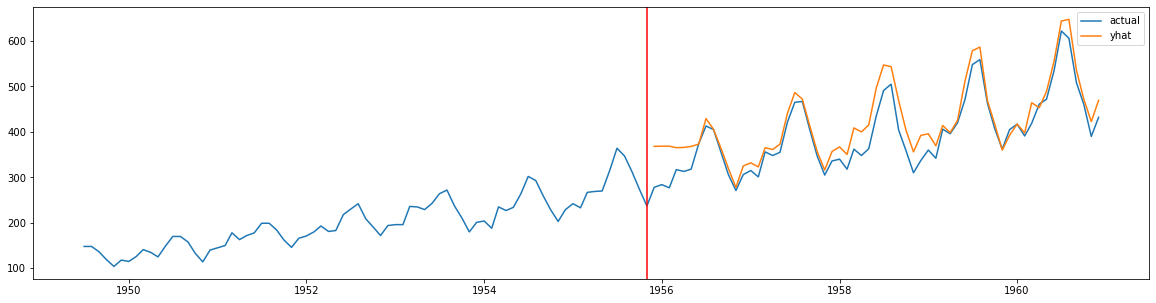

In [32]:
plt.figure(figsize=(20, 5))
TRAIN_M = 60*24
plt.plot(raw_df['Month'], raw_df[TARGET], label='actual')
plt.plot(valid_data['Month'], valid_data['yhat'], label='yhat')
plt.axvline(train_data['Month'].max(), color='red')
plt.legend()

In [33]:
# can we see what is doing

In [34]:
cnn1_weight = model.cnns[0][0].weight.data.detach().numpy()

In [35]:
cnn1_weight = cnn1_weight.reshape(cnn1_weight.shape[0], cnn1_weight.shape[2])

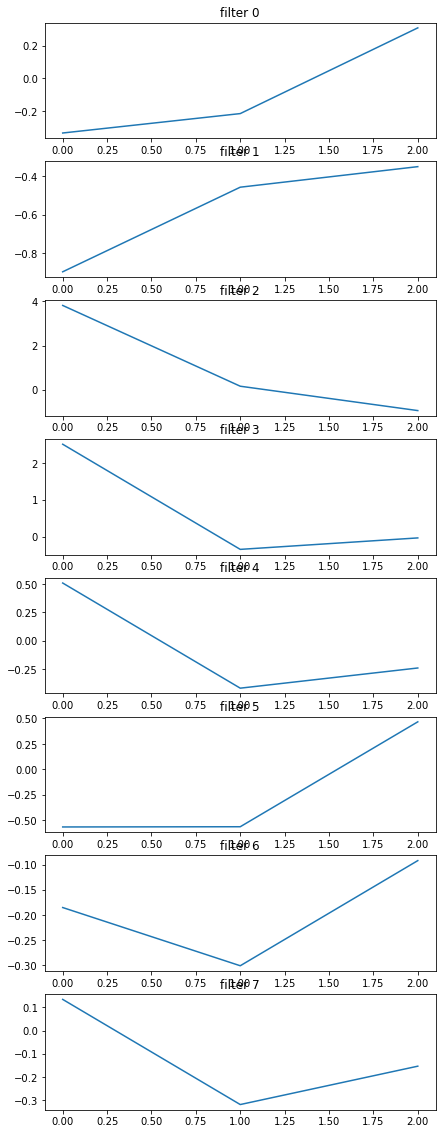

In [36]:
f, ax = plt.subplots(nrows=len(cnn1_weight), figsize=(7, 20))
for i in range(len(cnn1_weight)):
    ax[i].plot(cnn1_weight[i])
    ax[i].set_title(f'filter {i}')

In [37]:
train_x = torch.from_numpy(train_data[['lag']].to_numpy().reshape(1, -1, 1).astype(np.float32))

In [38]:
cnn_output = model.cnns[0][0](train_x.transpose(2, 1))

In [39]:
cnn_output = cnn_output.detach().transpose(2, 1).numpy()

In [40]:
cnn_output.shape

(1, 75, 8)

In [41]:
raw_f = train_data['lag'].values

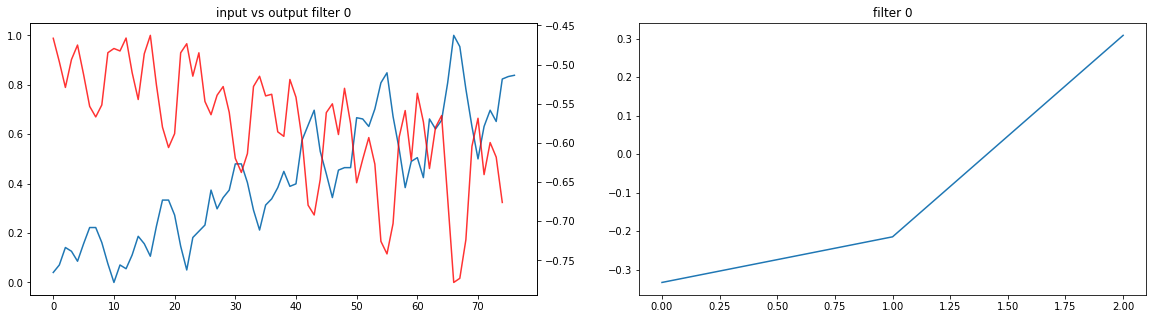

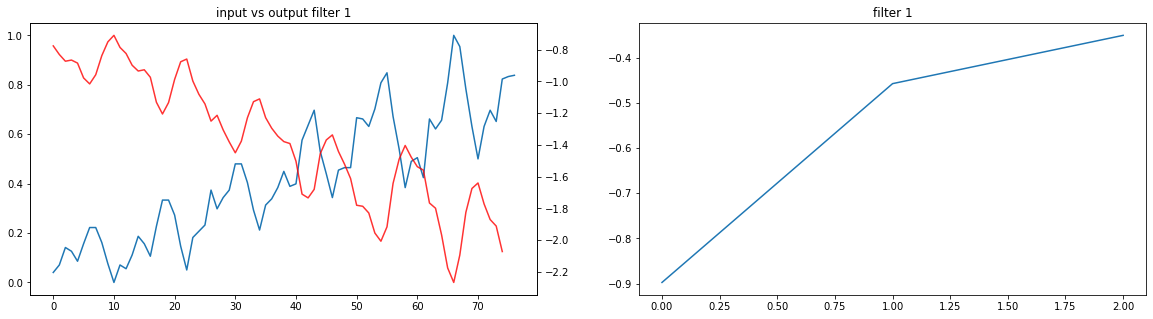

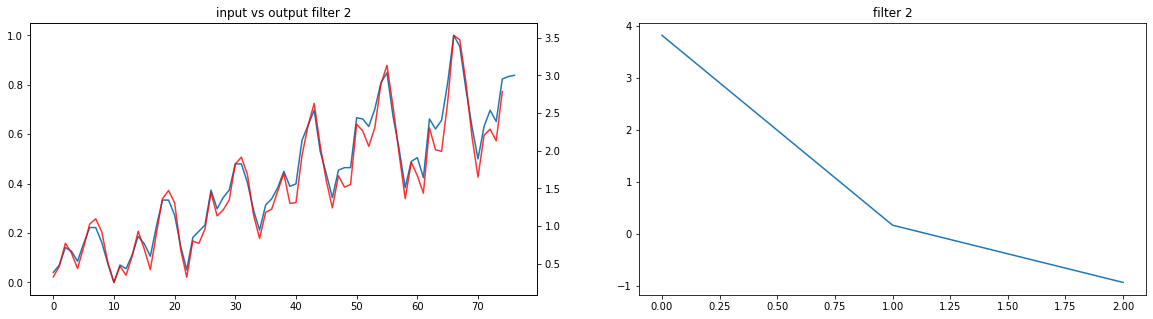

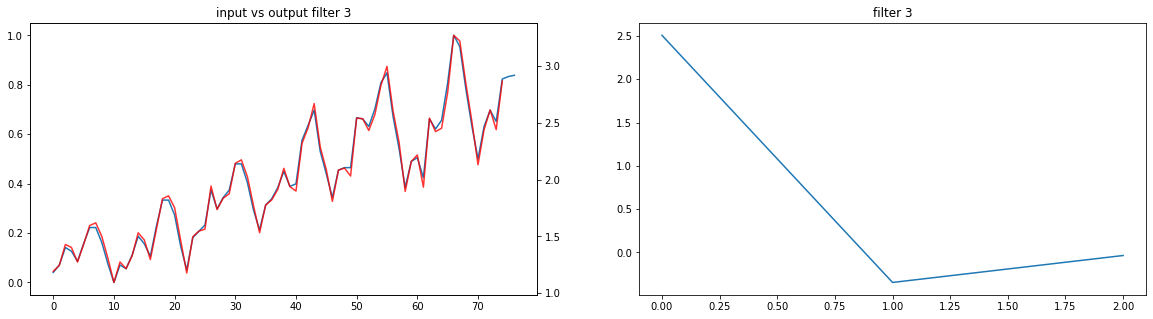

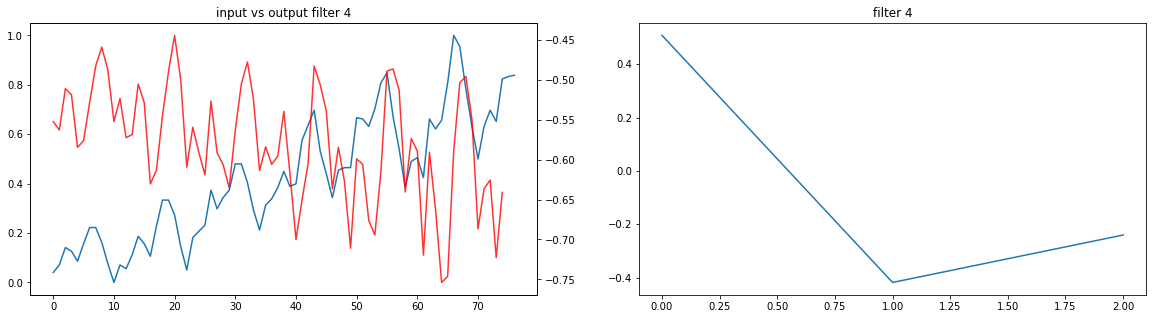

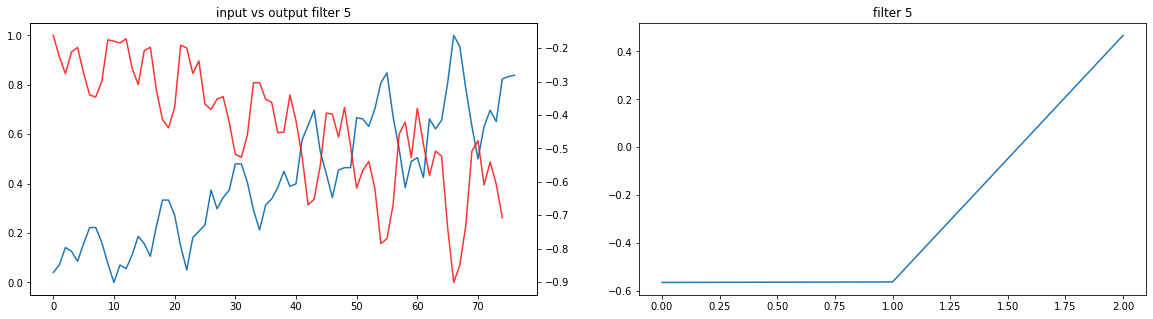

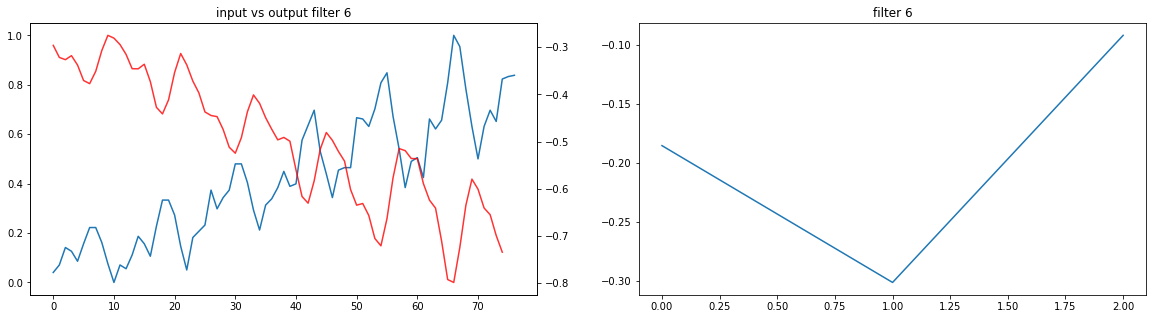

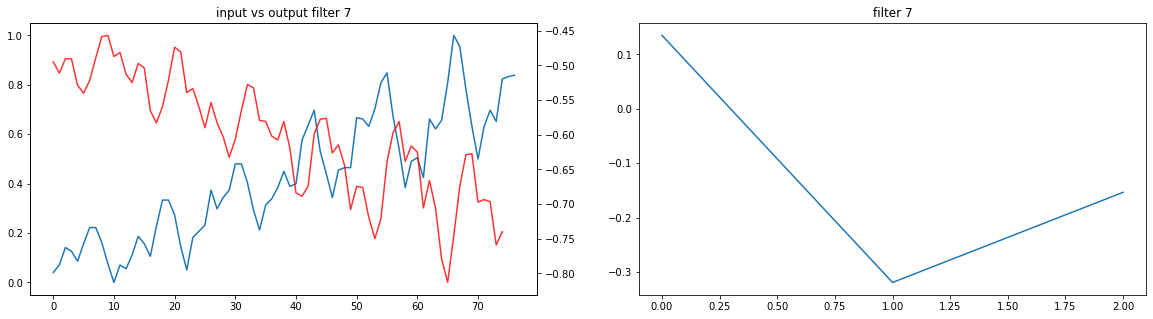

In [42]:
for i in range(len(cnn1_weight)):
    f, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(raw_f, label='input')
    tinwx = ax[0].twinx()
    tinwx.plot(cnn_output[0, :, i], color='red', alpha=0.8, label='output')
    ax[1].plot(cnn1_weight[i])
    ax[0].set_title(f'input vs output filter {i}')
    ax[1].set_title(f'filter {i}')